In [574]:
from mnist import MNIST 
import numpy as np
from pylab import *
from matplotlib import colors
%matplotlib inline

mndata = MNIST('./data')

mndata.load_training()
img_side = 28
n_mnist_pixels = img_side*img_side

In [575]:
labels = mndata.train_labels

cluster_size = 10
train_inputs_idx = []
for idx in [0, 4]:
    label_idx = np.where(np.isin(labels,[idx]))[0][:cluster_size]
    train_inputs_idx.append(label_idx)

samples_idx = np.array(train_inputs_idx, dtype='int').flatten()
samples_idx.size

20

In [576]:
images = []
for sample_idx in samples_idx.flatten():
    images.append(mndata.train_images[sample_idx])

images = np.array(images, dtype='float')
images = images / 255
images.shape

(20, 784)

In [577]:
def simple_plot(T: list):
    T_arr = np.array(T, dtype=float)

    fig, axs = plt.subplots(1, 1, figsize=(50, 5), tight_layout=True)
    axs.plot(np.arange(T_arr.size), T_arr)


    plt.show()

In [578]:
from typing import Literal

def show_image(image: ndarray, cmap: Literal['bone', 'Greys'] = 'bone'):
    # figure(figsize=(15, 10))

    imshow(np.array(image),
        interpolation='none',
        aspect='equal',
        cmap=cmap,
        )

    axis("off")

    show()

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 8. 7. 6. 5. 4. 0. 0.]
 [0. 0. 8. 0. 8. 7. 6. 5. 0. 0.]
 [0. 0. 7. 8. 0. 8. 7. 6. 0. 0.]
 [0. 0. 6. 7. 8. 0. 8. 7. 0. 0.]
 [0. 0. 5. 6. 7. 8. 0. 8. 0. 0.]
 [0. 0. 4. 5. 6. 7. 8. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


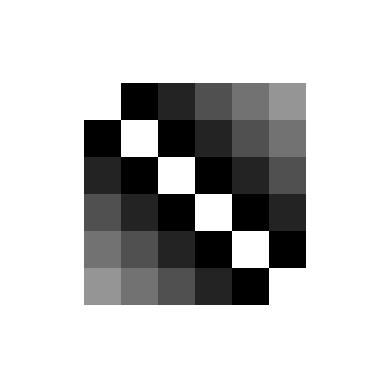

In [579]:
def get_discount_matrix(size, rev = False, cor_supr_size=0):
    a = np.arange(size)
    if rev:
        a = np.abs(np.abs(a - a[np.newaxis].T) - np.max(a))
    else:
        a = np.abs(a - a[np.newaxis].T)
    np.fill_diagonal(a, 0)

    if cor_supr_size > 0:
        a[:cor_supr_size] = 0
        a[:, 0:cor_supr_size] = 0
        a[-cor_supr_size:] = 0
        a[:, -cor_supr_size:] = 0

    return a

a = get_discount_matrix(10, rev=True, cor_supr_size=2)
a = np.array(a, dtype='float')
# a[:, 0:2] = 0
print(a)
show_image(a, cmap='Greys')

In [580]:
def show_images_table(images_2d: ndarray, img_side: int = 28, row_size=10):
    column_size = int(images.shape[0] / row_size)

    shaped_images = images_2d.reshape(column_size, row_size, img_side, img_side)
    shaped_images = shaped_images.swapaxes(1, 2).reshape(column_size*img_side, row_size*img_side)

    figure(figsize=(15, 10))

    imshow(shaped_images,
           interpolation='none',
           aspect='equal',
           cmap='bone',
           )
    
    axis("off")

# show_images_table(images_2d=images)
images.shape

(20, 784)

In [581]:
def infer(input: ndarray, W: ndarray, iter_cnt: int):
    I = np.copy(input)

    O = np.zeros(I.size)

    T = []
    OST = []

    for iter_idx in range(iter_cnt):
        DO = np.exp((I - W)**2 * -20.0)
        O += np.sum(DO, axis=1)

        O = O ** 2

        # inhibition
        O[np.where(O < np.mean(O))] = 0

        # recur
        O /= np.max(O)

        I = np.copy(O)

        # stats
        # t = np.sum(O > 0)
        t = np.mean(O)
        # t = np.sum(O)

        T.append(t)

        OST.append(np.copy(O))
    
    return T, OST


In [582]:
a = np.array([[1, 2, 3, 4], [5, 6, 7, 8]])
m = np.array([1, 2, 3, 4])
m
n = m*2
# nm = n * m[np.newaxis].T
nm = n[np.newaxis].T * m
nm

array([[ 2,  4,  6,  8],
       [ 4,  8, 12, 16],
       [ 6, 12, 18, 24],
       [ 8, 16, 24, 32]])

In [583]:
b = np.arange(8)
b[-2:] = 0
b[:2] = 0
b

array([0, 0, 2, 3, 4, 5, 0, 0])

- TODO: temporal W during relaxation, then update real W
- TODO: statistical (axonal) weights. Update S during relaxing? Energy is amount of active Neurons or dendrite error?
- TODO: Temperatura - increase then decrease.
- TODO: weight decay

- TODO: associative (serotonin) weights update?

In [584]:
def relax(I: ndarray,
          inp_S: ndarray,
          W: ndarray,
          inp_NS: ndarray,
          NW: ndarray,
          iter_cnt=100,
          ddsc=1.0,
          s_axis = 0,
          eps0=0.01,):
    S = np.copy(inp_S)
    NS = np.copy(inp_NS)
    O = np.zeros(S.shape[0])

    prev_S = np.copy(inp_S)
    prev_NS = np.copy(inp_NS)
    prev_O = np.copy(O)

    SP = []
    MP = []
    CP = []
    DP = []

    OST = []

    for iter_idx in range(iter_cnt):

        # infer
        np.fill_diagonal(S, 0)
        SO = I * S
        DO = np.exp((SO - W)**2 * -20.0)
        np.fill_diagonal(DO, 0)
        dO = np.sum(DO, axis=1)
        dO /= np.max(dO)
        O += dO

        # inhibition infer
        np.fill_diagonal(NS, 0)
        NSO = O * NS
        NDO = np.exp((NSO - NW)**2 * -20.0)
        np.fill_diagonal(NDO, 0)
        dNO = np.sum(NDO, axis=1)
        dNO /= np.max(dNO)
        O -= dNO

        # inhibition
        O[np.where(O < 0)] = 0

        # train inh stats S
        NO = O / np.max(O)
        ddS = NO * I[np.newaxis].T

        dNS = np.copy(ddS)

        # inh update
        NS += dNS**ddsc

        # train stats S
        dS = np.copy(ddS)

        # update
        S += dS**ddsc

        # stats
        SP.append(np.sum(O))
        MP.append(np.mean(O[np.where(O > 0)]))
        CP.append(np.sum(O > 0))
        DP.append(np.sum(np.abs(SO - W) + np.abs(NSO - NW)))

        # recur
        O /= np.max(O)

        I = np.copy(O)

        max_S = np.max(S, axis=s_axis)
        if np.max(max_S) > 1:
            # print(f'{np.max(max_S)=}')
            if s_axis == 1:
                S /= max_S[np.newaxis].T
            else:
                S /= max_S
            # print(f'{np.max(S)=}')

        max_NS = np.max(NS, axis=s_axis)
        if np.max(max_NS) > 1:
            # print(f'{np.max(max_NS)=}')
            if s_axis == 1:
                NS /= max_NS[np.newaxis].T
            else:
                NS /= max_NS

        # prev
        prev_S = np.copy(S)
        prev_NS = np.copy(NS)
        prev_O = np.copy(O)

        # stats
        OST.append(np.copy(O))

        # break
        if iter_idx > 1 and MP[iter_idx-1] > MP[iter_idx] and MP[iter_idx-1] > MP[iter_idx - 2]:
            # break
            depth = (MP[iter_idx-1] - MP[iter_idx]) + (MP[iter_idx-1] - MP[iter_idx - 2])
            print(f'Mean Out break: {iter_idx-1=} {depth=}')
        
        if iter_idx > 1 and DP[iter_idx-1] < DP[iter_idx] and DP[iter_idx-1] < DP[iter_idx - 2]:
            depth = (DP[iter_idx] - DP[iter_idx-1]) + (DP[iter_idx - 2] - DP[iter_idx-1])
            print(f'Err break: {iter_idx-1=} {depth=}')

    return prev_S, prev_NS, prev_O, SP, MP, CP, DP, OST


In [596]:
layer_size = n_mnist_pixels

I = np.zeros(n_mnist_pixels)
O = np.zeros(layer_size)
W = np.random.rand(O.size, I.size)
NW = np.random.rand(O.size, I.size)

s_c = 0.01
S = np.random.rand(O.size, I.size) * s_c
NS = np.random.rand(O.size, I.size) * s_c

print('W', W.shape, W.max(), W.min(), np.median(W))
print(f'{S.shape=} {S.max()=} {S.min()=} {np.median(S)=}')

thre_S = 0.05

iter_cnt = 100 * 1

eps0 = 0.01
eps = eps0

for img in images[:1]:
    I = np.copy(img)
    print(f'{I.shape=} {I.max()=} {I.min()=} {np.median(I)=}')

    prev_S, prev_NS, prev_O, SP, MP, CP, DP, OST = relax(I=I,
                                                         inp_S=S,
                                                         W=W,
                                                         inp_NS=NS,
                                                         NW=NW,
                                                         iter_cnt=100,
                                                         ddsc=2.0,
                                                         s_axis=0,
                                                         eps0=0.01,)

    # # eps = (iter_cnt - iter_idx) * eps0

    # threshold = np.mean(O)
    # # threshold = np.median(O[np.where(O > 0)])

    # # inh train
    # dNW = (O - NW) * eps
    # dNW[np.where(O > threshold)] = 0

    # # train inh stats S
    # NO = O / np.max(O)
    # ddS = NO * I[np.newaxis].T # * (eps * 1.0)

    # dNS = np.copy(ddS)
    # # dNS[np.where(O > threshold)] = 0

    # ddsc = 1.0
    # # inh update
    # # NW += dNW
    # NS += dNS**ddsc

    # # train
    # dW = (I - W) * eps
    # dW[np.where(O <= threshold)] = 0

    # # train stats S
    # dS = np.copy(ddS)
    # # dS[np.where(O <= threshold)] = 0

    # # update
    # # W += dW
    # S += dS**ddsc

    # # stats
    # SP.append(np.sum(O))
    # MP.append(np.mean(O[np.where(O > 0)]))
    # CP.append(np.sum(O > 0))
    # DP.append(np.sum(np.abs(SO - W) + np.abs(NSO - NW)))

    # # recur
    # O /= np.max(O)

    # I = np.copy(O)

    # max_S = np.max(S, axis=1)
    # if np.max(max_S) > 1:
    #     print(f'{np.max(max_S)=}')
    #     S /= max_S[np.newaxis].T
    #     print(f'{np.max(S)=}')

    # max_NS = np.max(NS, axis=1)
    # if np.max(max_NS) > 1:
    #     # print(f'{np.max(max_NS)=}')
    #     NS /= max_NS[np.newaxis].T

    # # stats
    # OST.append(np.copy(O))

    # # eps = eps + eps * 0.1

    S = np.copy(prev_S)

print('W', W.shape, W.max(), W.min(), np.median(W))
print(f'{S.shape=} {S.max()=} {S.min()=} {np.median(S)=}')

W (784, 784) 0.9999980425297548 1.3421196665142077e-07 0.49892634686008225
S.shape=(784, 784) S.max()=0.009999995958982206 S.min()=7.277155767981824e-09 np.median(S)=0.005002926538345732
I.shape=(784,) I.max()=1.0 I.min()=0.0 np.median(I)=0.0
Err break: iter_idx-1=1 depth=92846.69241732726
Mean Out break: iter_idx-1=3 depth=0.05039310066944841
Err break: iter_idx-1=4 depth=724.590400720539
Mean Out break: iter_idx-1=10 depth=0.005199198521972703
Err break: iter_idx-1=13 depth=213.7193558794097
Mean Out break: iter_idx-1=14 depth=0.0035526416145635897
Mean Out break: iter_idx-1=16 depth=0.0031068897439824883
Mean Out break: iter_idx-1=22 depth=0.003752166260981127
Mean Out break: iter_idx-1=25 depth=0.0009667939288292293
Mean Out break: iter_idx-1=27 depth=0.0032455223824846835
Mean Out break: iter_idx-1=31 depth=0.00581451813182457
Mean Out break: iter_idx-1=34 depth=0.0006867925652520868
Mean Out break: iter_idx-1=38 depth=0.0032189204021050577
Mean Out break: iter_idx-1=41 depth=0.00

In [597]:
# a = 1
# cnt = 100
# A =[]
# for i in range(cnt):
#     a = (a + a * 0.05)
#     # a = (a0 ** i) * 0.01
#     A.append(a * 0.01)

# simple_plot(A)

CP[-1]=226


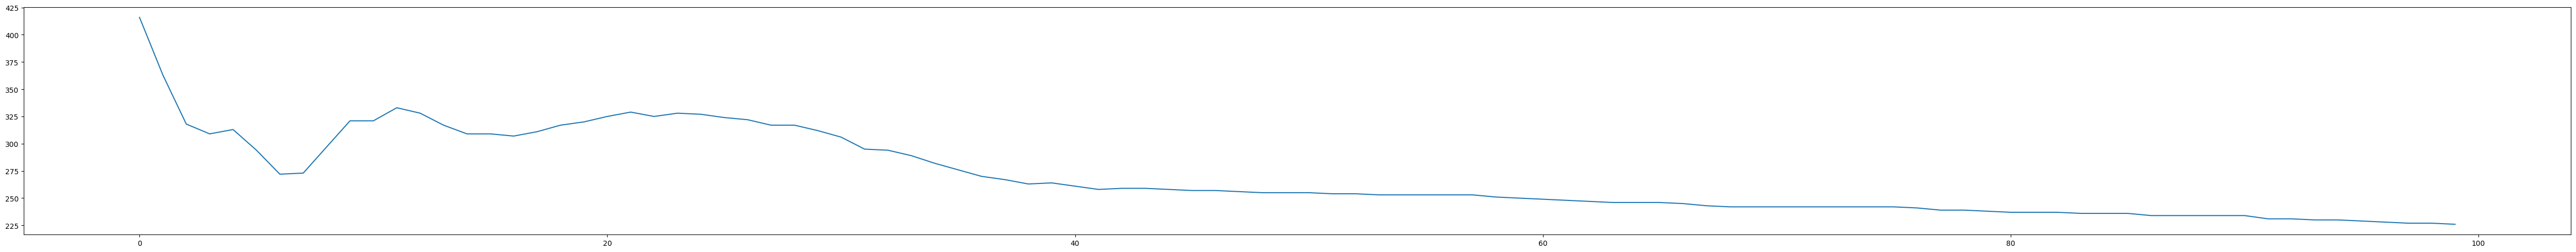

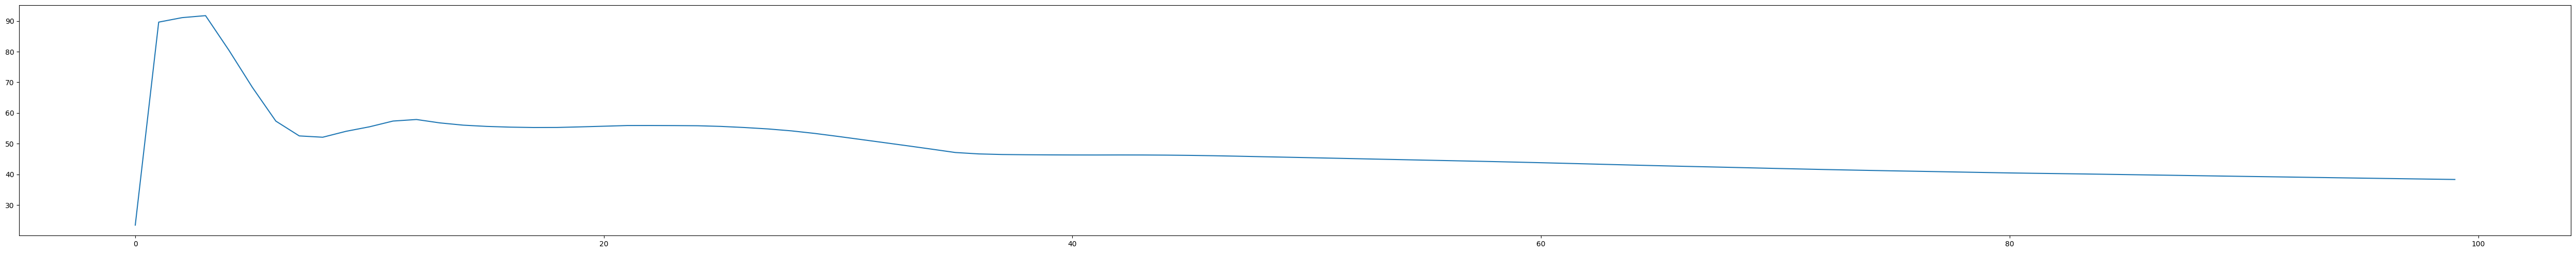

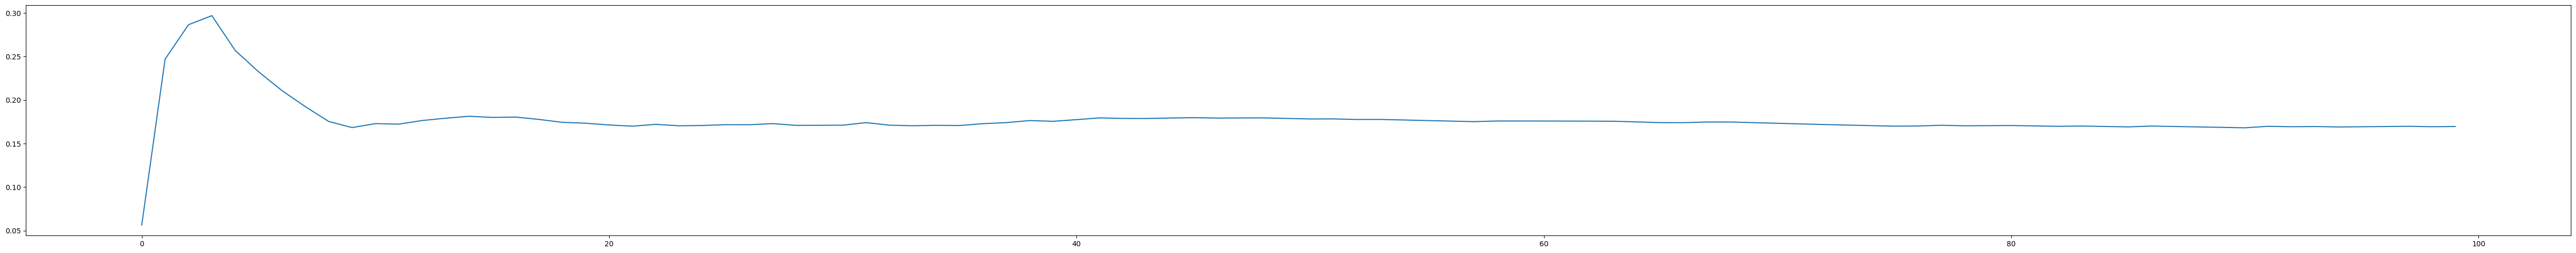

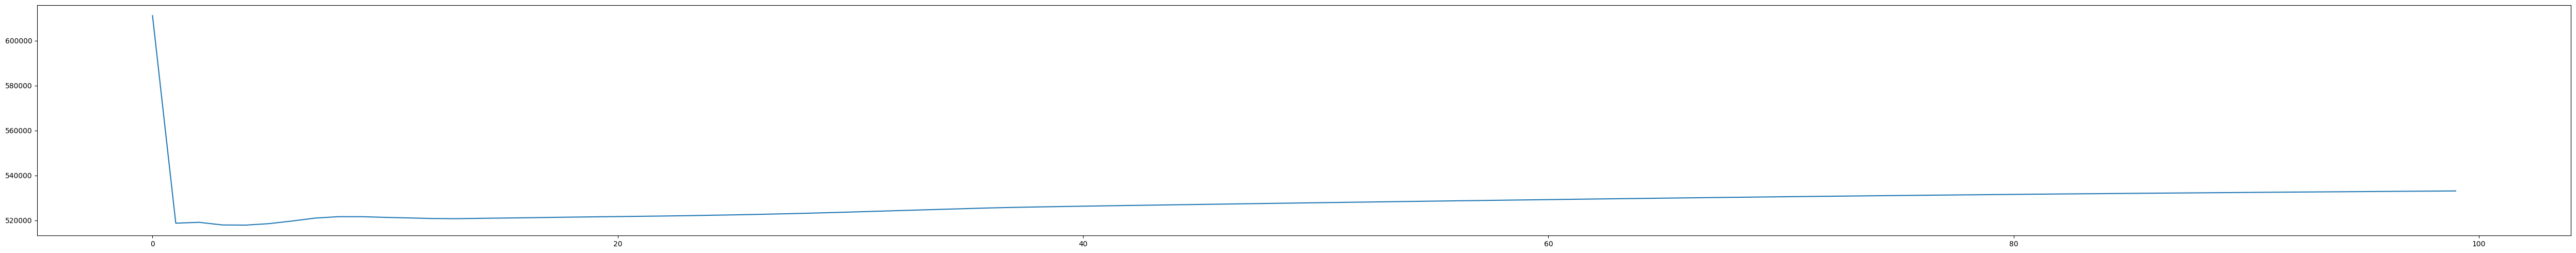

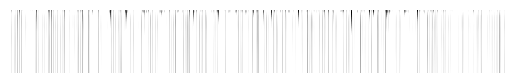

In [598]:
print(f'{CP[-1]=}')
simple_plot(T=CP)
simple_plot(T=SP)
simple_plot(T=MP)
simple_plot(T=DP)

show_image(image=OST, cmap='Greys')

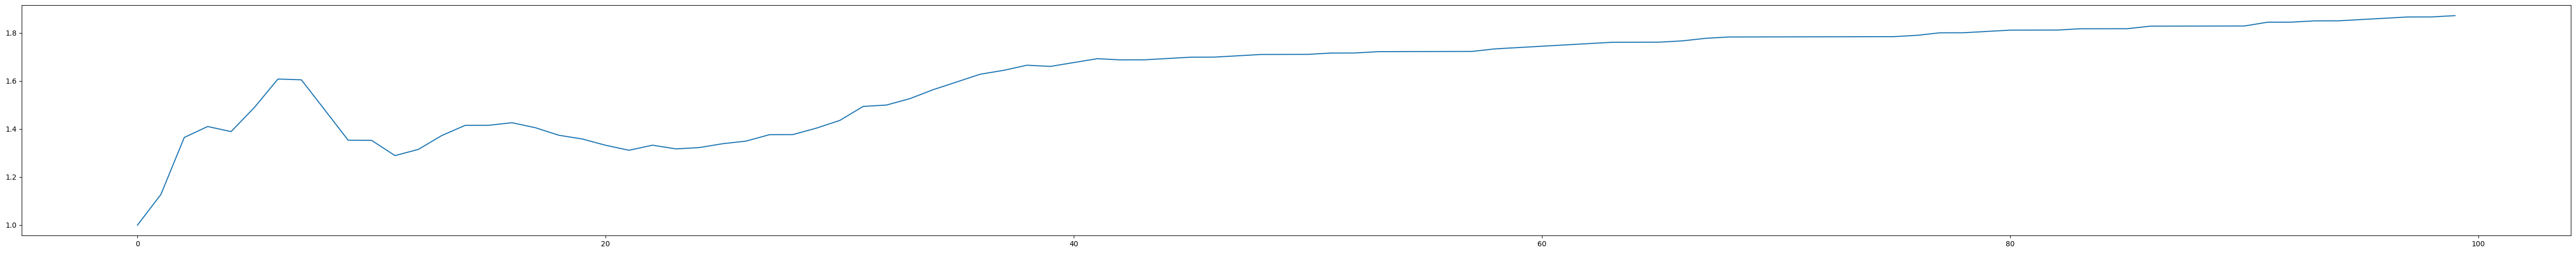

array([1.        , 1.127659  , 1.36512623, 1.41057611, 1.38940312])

In [599]:
arr_CP = np.array(CP, dtype=float)
arr_DP = np.array(DP, dtype=float)
arr_CP = arr_CP.max() - arr_CP
arr_CP /= arr_CP.max()

arr_DP /= arr_DP.max()
# inv_DP = 1 / arr_DP

arr_SU = arr_DP + arr_CP

simple_plot(T=arr_SU)
arr_SU[:5]

In [600]:
CP[:5]

[416, 363, 318, 309, 313]

In [601]:
DP[:5]

[611181.3539079125,
 518716.7247678702,
 519098.7880451552,
 517926.21433344454,
 517852.6522625502]

In [602]:
a = np.array([[1,2,3,4],[5,6,7,8]]) * 1.0
max_a = np.max(a, axis=1) * 1.0
# a * (a > 2)
a /= max_a[np.newaxis].T
a

array([[0.25 , 0.5  , 0.75 , 1.   ],
       [0.625, 0.75 , 0.875, 1.   ]])

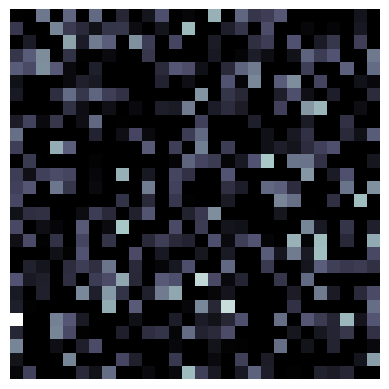

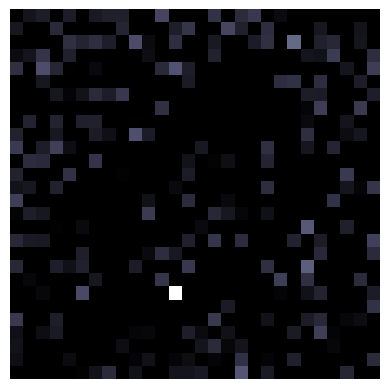

In [603]:
al = np.copy(OST[0])
al = al.reshape(img_side, img_side)
show_image(al)

al = np.copy(OST[-1])
al = al.reshape(img_side, img_side)
show_image(al)

In [604]:
# arr = np.array(MP[125:135])
# arr = arr - np.pad(arr, (1, 0))[:-1]
# CP[130]

i_T[-1]=0.40471917412768343


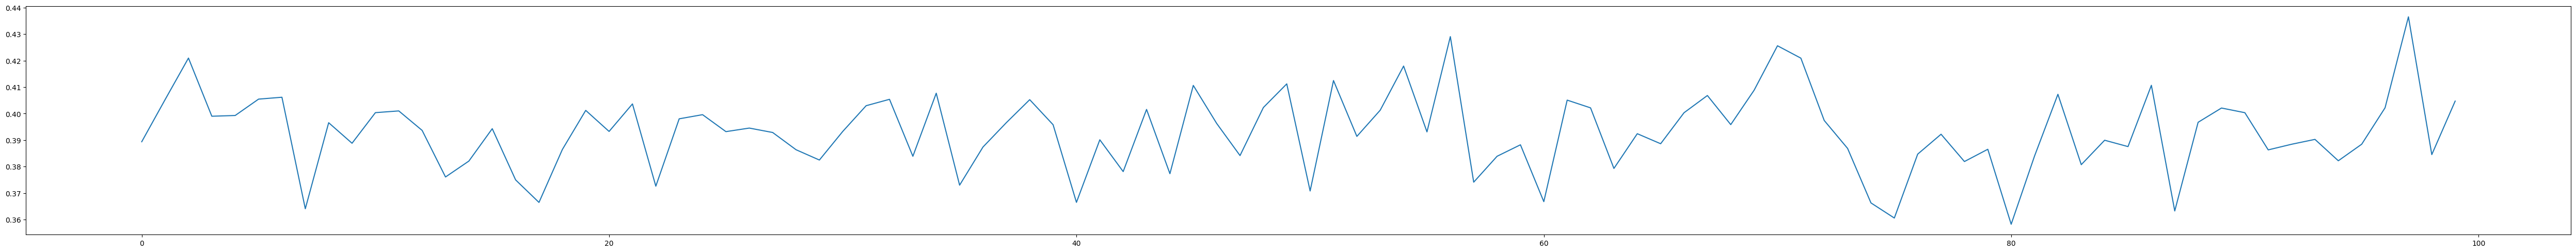

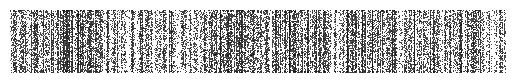

In [605]:
i_T, i_OST = infer(input=images[1], W=W, iter_cnt=iter_cnt)

print(f'{i_T[-1]=}')
simple_plot(T=i_T)

show_image(image=i_OST, cmap='Greys')

[[  0.   2.   4. ... 194. 196. 198.]
 [  2.   0.   2. ... 192. 194. 196.]
 [  4.   2.   0. ... 190. 192. 194.]
 ...
 [194. 192. 190. ...   0.   2.   4.]
 [196. 194. 192. ...   2.   0.   2.]
 [198. 196. 194. ...   4.   2.   0.]]


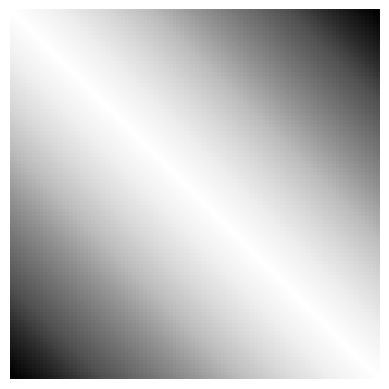

In [606]:
a = get_discount_matrix(100)
a = np.array(a, dtype='float')
a *= 2
print(a)
show_image(a, cmap='Greys')